<a href="https://colab.research.google.com/github/lucasresck/deep-learning-and-applications/blob/main/cnn/cnn_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN architectures comparison

[Deep Learning and Applications](https://emap.fgv.br/sites/emap.fgv.br/files/ementa_deep_learning_and_applications.pdf)
summer course (2021, FGV).

**Group**:
- Humberto Seghetto dos Santos (PUC-Rio)
- Lucas Emanuel Resck Domingues (FGV-EMAp)

## Description

We will make various experiments with CNNs layers, activation functions and regularization techniques, and we will compare the results.

1. **Objective**: Use or create a deep CNN for COVID data set.
2. **Activities**: Create a deep model in PyTorch.
3. **Experiments**:
    - Increment number layer, from 1 to 5, and  analyze the results.
    - Experiment by changing the activation  functions (Tanh, ReLU) and analyze the results.
    - Experiment changing regularization strategies (1. without regularization; 2. with batch normalization; 3. with dropout).
    - With  a CNN with 3 layer, use kernel size:
        - (7x7,5x5,3x3)
        - (5x5,5x5,3x3)
        - (3x3,3x3,3x3)
4. Conclude from the results.


## Setup

We install the required libraries, set up the GPU support and also set up the Kaggle support.

In [1]:
# Install libraries
!pip install -q kaggle  # For Kaggle dataset
!pip install -q split-folders  # Split the data

In [2]:
# Import libraries
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import splitfolders
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

sns.set()

In [3]:
# GPU setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
# Setup for downloading the Kaggle dataset
files.upload()  # Upload the Kaggle user API key
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Data

We download the COVID dataset from Kaggle, and we split the data.

In [5]:
# Download the files
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip them
!unzip -q covid19-radiography-database.zip

# Remove files and folders
!rm 'covid19-radiography-database.zip'
!rm 'COVID-19 Radiography Database/COVID.metadata.xlsx'
!rm 'COVID-19 Radiography Database/NORMAL.metadata.xlsx'
!rm 'COVID-19 Radiography Database/README.md.txt'
!rm -rf 'COVID-19 Radiography Database/Viral Pneumonia'
!rm 'COVID-19 Radiography Database/Viral Pneumonia.metadata.xlsx'

# Split data
splitfolders.ratio(
    'COVID-19 Radiography Database',
    output='data',
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)

# Delete old files
!rm -rf 'COVID-19 Radiography Database'

100% 1.14G/1.14G [00:07<00:00, 219MB/s]
100% 1.14G/1.14G [00:07<00:00, 162MB/s]


Copying files: 2541 files [00:13, 182.93 files/s]


The resulting directory looks like that:

```
data/
    train/
        COVID/
            img1.jpg
            ...
        NORMAL/
            imga.jpg
            ...
    val/
        COVID/
            img2.jpg
            ...
        NORMAL/
            imgb.jpg
            ...
    test/
        COVID/
            img3.jpg
            ...
        NORMAL/
            imgc.jpg
            ...
```



We import the data sets and create the data loaders.

In [6]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(256)
])
train_set = torchvision.datasets.ImageFolder(
    root='data/train',
    transform=transformation
)
val_set = torchvision.datasets.ImageFolder(
    root='data/val',
    transform=transformation
)
test_set = torchvision.datasets.ImageFolder(
    root='data/test',
    transform=transformation
)

In [7]:
print('The number of images is {}.'.format(len(train_set)+len(val_set)+len(test_set)))

The number of images is 2541.


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=64,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=64,
    shuffle=False
)

Here's an example of an image of the train dataset.

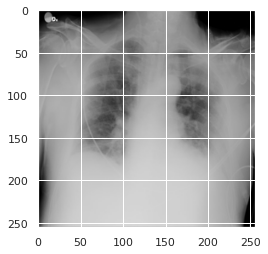

In [9]:
plt.imshow(transforms.ToPILImage()(train_set[0][0]));

## Experiments

Here we perform the experiments proprosed in the beggining of our notebook.

In [10]:
# Hyperparameters
lr = 0.001
n_epochs = 3

### Layers

We vary the number of layers of the CNN and discuss the results.

#### 1 layer

In [11]:
class CNN_1_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(
            in_features=16*128*128,
            out_features=64
        )
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.reshape(-1, 16*128*128)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x


cnn_1_layer = CNN_1_layer().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_1_layer.parameters(), lr=lr)

In [12]:
def train(model, optimizer, loss_function):
    losses = []
    val_losses = []
    val_accs = []
    for epoch in range(n_epochs):
        running_loss = 0
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()

            imgs, labels = data
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(
                    epoch+1,
                    n_epochs,
                    i+1,
                    len(train_loader),
                    loss.item()
                ))

        running_loss = running_loss/len(train_loader)
        print('Epoch [{}/{}], Mean loss: {:.4f}' .format(
            epoch+1,
            n_epochs,
            running_loss
        ), end='')
        losses.append(running_loss) 

        model.eval()
        val_loss = 0
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
        val_acc = correct/total
        val_accs.append(val_acc)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(', Val loss: {:.4f}, Val acc: {:.3f}'.format(val_loss, val_acc))

In [13]:
train(cnn_1_layer, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.0570
Epoch [1/3], Step [20/32], Loss: 0.1375
Epoch [1/3], Step [30/32], Loss: 0.0099
Epoch [1/3], Mean loss: 0.3888, Val loss: 0.0634, Val acc: 0.976
Epoch [2/3], Step [10/32], Loss: 0.0302
Epoch [2/3], Step [20/32], Loss: 0.0090
Epoch [2/3], Step [30/32], Loss: 0.0060
Epoch [2/3], Mean loss: 0.0295, Val loss: 0.0318, Val acc: 0.988
Epoch [3/3], Step [10/32], Loss: 0.0303
Epoch [3/3], Step [20/32], Loss: 0.0029
Epoch [3/3], Step [30/32], Loss: 0.0025
Epoch [3/3], Mean loss: 0.0114, Val loss: 0.0309, Val acc: 0.988


In [14]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct/total
    print('The accuracy of the model on test set is {:.4f}.'.format(acc))
    return acc

In [15]:
acc_layers = [test(cnn_1_layer)]

The accuracy of the model on test set is 0.9922.


#### 2 layers

In [16]:
class CNN_2_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.linear1 = nn.Linear(64*64*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape(-1, 64*64*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_2_layers = CNN_2_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_2_layers.parameters(), lr=lr)

In [17]:
train(cnn_2_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.3094
Epoch [1/3], Step [20/32], Loss: 0.0699
Epoch [1/3], Step [30/32], Loss: 0.0853
Epoch [1/3], Mean loss: 0.3936, Val loss: 0.1172, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.0159
Epoch [2/3], Step [20/32], Loss: 0.0410
Epoch [2/3], Step [30/32], Loss: 0.0056
Epoch [2/3], Mean loss: 0.0530, Val loss: 0.0387, Val acc: 0.984
Epoch [3/3], Step [10/32], Loss: 0.0195
Epoch [3/3], Step [20/32], Loss: 0.0513
Epoch [3/3], Step [30/32], Loss: 0.0123
Epoch [3/3], Mean loss: 0.0364, Val loss: 0.0536, Val acc: 0.980


In [18]:
acc_layers.append(test(cnn_2_layers))

The accuracy of the model on test set is 0.9725.


#### 3 layers

In [19]:
class CNN_3_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_3_layers = CNN_3_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_3_layers.parameters(), lr=lr)

In [20]:
train(cnn_3_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.1436
Epoch [1/3], Step [20/32], Loss: 0.0996
Epoch [1/3], Step [30/32], Loss: 0.0183
Epoch [1/3], Mean loss: 0.1681, Val loss: 0.1235, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.0378
Epoch [2/3], Step [20/32], Loss: 0.0287
Epoch [2/3], Step [30/32], Loss: 0.0801
Epoch [2/3], Mean loss: 0.0534, Val loss: 0.0796, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.1314
Epoch [3/3], Step [20/32], Loss: 0.0396
Epoch [3/3], Step [30/32], Loss: 0.0046
Epoch [3/3], Mean loss: 0.0475, Val loss: 0.0722, Val acc: 0.976


In [21]:
acc_layers.append(test(cnn_3_layers))

The accuracy of the model on test set is 0.9843.


#### 4 layers

In [22]:
class CNN_4_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(16*16*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.reshape(-1, 16*16*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_4_layers = CNN_4_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_4_layers.parameters(), lr=lr)

In [23]:
train(cnn_4_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.4248
Epoch [1/3], Step [20/32], Loss: 0.1011
Epoch [1/3], Step [30/32], Loss: 0.1517
Epoch [1/3], Mean loss: 0.3230, Val loss: 0.1579, Val acc: 0.965
Epoch [2/3], Step [10/32], Loss: 0.1261
Epoch [2/3], Step [20/32], Loss: 0.0413
Epoch [2/3], Step [30/32], Loss: 0.1959
Epoch [2/3], Mean loss: 0.0970, Val loss: 0.0902, Val acc: 0.976
Epoch [3/3], Step [10/32], Loss: 0.1375
Epoch [3/3], Step [20/32], Loss: 0.0607
Epoch [3/3], Step [30/32], Loss: 0.0184
Epoch [3/3], Mean loss: 0.0616, Val loss: 0.0829, Val acc: 0.969


In [24]:
acc_layers.append(test(cnn_4_layers))

The accuracy of the model on test set is 0.9647.


#### 5 layers

In [25]:
class CNN_5_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 32, 3, 1, 1)
        self.conv5 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(8*8*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = x.reshape(-1, 8*8*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_5_layers = CNN_5_layers().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_5_layers.parameters(), lr=lr)

In [26]:
train(cnn_5_layers, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.6360
Epoch [1/3], Step [20/32], Loss: 0.0897
Epoch [1/3], Step [30/32], Loss: 0.1230
Epoch [1/3], Mean loss: 0.3879, Val loss: 0.1120, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.2345
Epoch [2/3], Step [20/32], Loss: 0.1212
Epoch [2/3], Step [30/32], Loss: 0.0300
Epoch [2/3], Mean loss: 0.0898, Val loss: 0.0876, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.0029
Epoch [3/3], Step [20/32], Loss: 0.0237
Epoch [3/3], Step [30/32], Loss: 0.0160
Epoch [3/3], Mean loss: 0.0675, Val loss: 0.0986, Val acc: 0.969


In [27]:
acc_layers.append(test(cnn_5_layers))

The accuracy of the model on test set is 0.9569.


#### Comparison

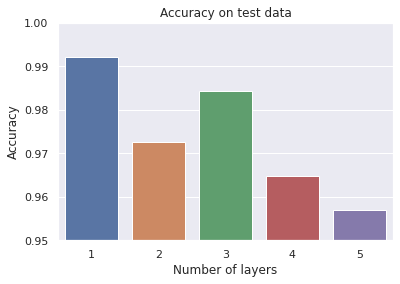

In [28]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=list(range(1, 6)), y=acc_layers, ax=ax)
ax.set_ylim([0.95, 1])
plt.title('Accuracy on test data')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was the one with **1 layer**.

### Activation functions

We experiment with some activate functions and discuss the results. Because of the experiments with various number of layers, we will choose to work with 1 layer.

#### ReLU

It was already fitted in the previous section (2 layers CNN).

In [29]:
acc_activation = [acc_layers[0]]

#### Tanh

In [30]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.tanh = nn.Tanh()
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*128*16, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = x.reshape(-1, 128*128*16)
        x = self.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_tanh = CNN_tanh().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_tanh.parameters(), lr=lr)

In [31]:
train(cnn_tanh, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 2.2578
Epoch [1/3], Step [20/32], Loss: 1.7422
Epoch [1/3], Step [30/32], Loss: 1.3049
Epoch [1/3], Mean loss: 1.9017, Val loss: 1.0585, Val acc: 0.528
Epoch [2/3], Step [10/32], Loss: 0.7410
Epoch [2/3], Step [20/32], Loss: 0.6842
Epoch [2/3], Step [30/32], Loss: 0.7057
Epoch [2/3], Mean loss: 0.7707, Val loss: 0.7018, Val acc: 0.472
Epoch [3/3], Step [10/32], Loss: 0.6964
Epoch [3/3], Step [20/32], Loss: 0.6945
Epoch [3/3], Step [30/32], Loss: 0.6912
Epoch [3/3], Mean loss: 0.6952, Val loss: 0.6913, Val acc: 0.528


In [32]:
acc_activation.append(test(cnn_tanh))

The accuracy of the model on test set is 0.5294.


#### Comparison

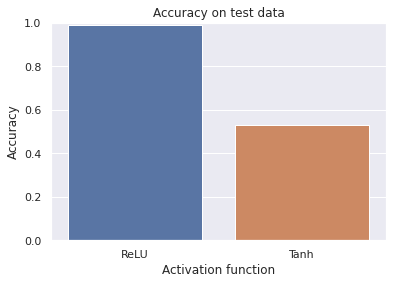

In [33]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['ReLU', 'Tanh'], y=acc_activation, ax=ax)
ax.set_ylim([0, 1])
plt.title('Accuracy on test data')
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.show()

With our results, we conclude that the best model was by far the one with **ReLU**.

### Regularization strategies

We experiment various regularization strategies.

#### Without regularization

Consider the 1 layer CNN with ReLU.

In [43]:
acc_regu = [acc_layers[0]]

#### Batch normalization

In [44]:
class CNN_batch_normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn_1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*128*16, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn_1(self.conv1(x))))
        x = x.reshape(-1, 128*128*16)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_batch_normalization = CNN_batch_normalization().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_batch_normalization.parameters(), lr=lr)

In [45]:
train(cnn_batch_normalization, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 3.2889
Epoch [1/3], Step [20/32], Loss: 0.6555
Epoch [1/3], Step [30/32], Loss: 4.5954
Epoch [1/3], Mean loss: 1.6628, Val loss: 0.8894, Val acc: 0.953
Epoch [2/3], Step [10/32], Loss: 0.0000
Epoch [2/3], Step [20/32], Loss: 0.0000
Epoch [2/3], Step [30/32], Loss: 0.0082
Epoch [2/3], Mean loss: 0.7856, Val loss: 2.3207, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.0000
Epoch [3/3], Step [20/32], Loss: 0.0000
Epoch [3/3], Step [30/32], Loss: 0.0000
Epoch [3/3], Mean loss: 0.6554, Val loss: 2.0653, Val acc: 0.957


In [46]:
acc_regu.append(test(cnn_batch_normalization))

The accuracy of the model on test set is 0.9333.


#### Dropout

In [47]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(128*128*16, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.dropout(self.relu(self.conv1(x))))
        x = x.reshape(-1, 128*128*16)
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

cnn_dropout = CNN_dropout().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_dropout.parameters(), lr=lr)

In [48]:
train(cnn_dropout, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 1.0402
Epoch [1/3], Step [20/32], Loss: 0.1566
Epoch [1/3], Step [30/32], Loss: 0.1798
Epoch [1/3], Mean loss: 1.8042, Val loss: 0.0849, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.0626
Epoch [2/3], Step [20/32], Loss: 0.3165
Epoch [2/3], Step [30/32], Loss: 0.0963
Epoch [2/3], Mean loss: 0.1584, Val loss: 0.0654, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.1588
Epoch [3/3], Step [20/32], Loss: 0.0785
Epoch [3/3], Step [30/32], Loss: 0.1968
Epoch [3/3], Mean loss: 0.1390, Val loss: 0.0766, Val acc: 0.972


In [49]:
acc_regu.append(test(cnn_dropout))

The accuracy of the model on test set is 0.9608.


#### Comparison

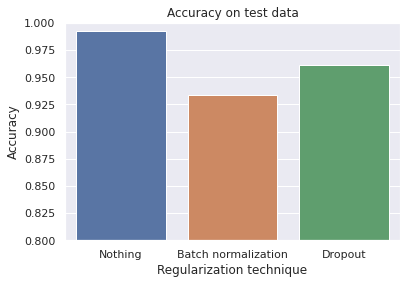

In [50]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['Nothing', 'Batch normalization', 'Dropout'], y=acc_regu, ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Regularization technique')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.show()

With our results, we conclude that the best model was the one without regularization.

### Kernel size

We experiment various kernel sizes.

#### (7x7, 5x5, 3x3)



In [51]:
class CNN_753(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 7, 1, 3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_753 = CNN_753().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_753.parameters(), lr=lr)

In [52]:
train(cnn_753, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.1560
Epoch [1/3], Step [20/32], Loss: 0.1987
Epoch [1/3], Step [30/32], Loss: 0.0761
Epoch [1/3], Mean loss: 0.2428, Val loss: 0.0747, Val acc: 0.969
Epoch [2/3], Step [10/32], Loss: 0.0385
Epoch [2/3], Step [20/32], Loss: 0.0831
Epoch [2/3], Step [30/32], Loss: 0.0758
Epoch [2/3], Mean loss: 0.0689, Val loss: 0.1181, Val acc: 0.969
Epoch [3/3], Step [10/32], Loss: 0.1876
Epoch [3/3], Step [20/32], Loss: 0.0702
Epoch [3/3], Step [30/32], Loss: 0.3670
Epoch [3/3], Mean loss: 0.1517, Val loss: 0.2453, Val acc: 0.972


In [53]:
acc_kernel = [test(cnn_753)]

The accuracy of the model on test set is 0.9490.


#### (5x5, 5x5, 3x3)



In [54]:
class CNN_553(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, 1, 2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_553 = CNN_553().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_553.parameters(), lr=lr)

In [55]:
train(cnn_553, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.1932
Epoch [1/3], Step [20/32], Loss: 0.0103
Epoch [1/3], Step [30/32], Loss: 0.1333
Epoch [1/3], Mean loss: 0.2621, Val loss: 0.0706, Val acc: 0.972
Epoch [2/3], Step [10/32], Loss: 0.0072
Epoch [2/3], Step [20/32], Loss: 0.1100
Epoch [2/3], Step [30/32], Loss: 0.2404
Epoch [2/3], Mean loss: 0.1090, Val loss: 0.1687, Val acc: 0.941
Epoch [3/3], Step [10/32], Loss: 0.1489
Epoch [3/3], Step [20/32], Loss: 0.0902
Epoch [3/3], Step [30/32], Loss: 0.0737
Epoch [3/3], Mean loss: 0.0736, Val loss: 0.0725, Val acc: 0.972


In [56]:
acc_kernel.append(test(cnn_553))

The accuracy of the model on test set is 0.9686.


#### (3x3, 3x3, 3x3)



In [57]:
class CNN_333(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 32, 3, 1, 1)
        self.linear1 = nn.Linear(32*32*32, 64)
        self.linear2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.reshape(-1, 32*32*32)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

cnn_333 = CNN_333().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_333.parameters(), lr=lr)

In [58]:
train(cnn_333, optimizer, loss_function)

Epoch [1/3], Step [10/32], Loss: 0.5787
Epoch [1/3], Step [20/32], Loss: 0.0590
Epoch [1/3], Step [30/32], Loss: 0.1802
Epoch [1/3], Mean loss: 0.3684, Val loss: 0.1408, Val acc: 0.961
Epoch [2/3], Step [10/32], Loss: 0.0435
Epoch [2/3], Step [20/32], Loss: 0.0052
Epoch [2/3], Step [30/32], Loss: 0.0310
Epoch [2/3], Mean loss: 0.0838, Val loss: 0.0871, Val acc: 0.972
Epoch [3/3], Step [10/32], Loss: 0.1658
Epoch [3/3], Step [20/32], Loss: 0.0704
Epoch [3/3], Step [30/32], Loss: 0.0430
Epoch [3/3], Mean loss: 0.0772, Val loss: 0.1018, Val acc: 0.969


In [59]:
acc_kernel.append(test(cnn_333))

The accuracy of the model on test set is 0.9647.


#### Comparison

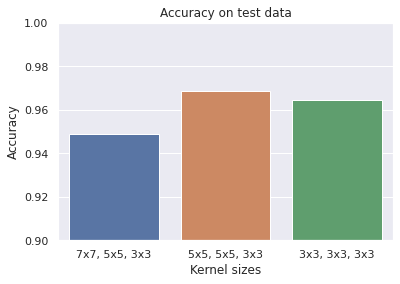

In [60]:
fig, ax = plt.subplots(1, 1)
sns.barplot(x=['7x7, 5x5, 3x3', '5x5, 5x5, 3x3', '3x3, 3x3, 3x3'], y=acc_kernel, ax=ax)
plt.title('Accuracy on test data')
plt.xlabel('Kernel sizes')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.show()

The best model was the one with kernel sizes (5x5x3).

## Conclusions

In general, based on our experiments, the best model for this task has some of these characteristics:
- 1 layer
- ReLU
- Without regularization
- 3 layers and kernel sizes (5x5x3)

In fact, our simple model with 1 layer, ReLU and no regularization performed the best.

It is very important to note that, because of the randomness of the processes, we could have had much different results.

## References

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.